In [7]:
import tensorflow as tf
import numpy as np
from keras.models import Sequential
from keras.layers import Conv1D, BatchNormalization, MaxPooling1D, Flatten, Dense, Dropout
from keras.regularizers import l2
from keras.utils import to_categorical
import librosa
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import os
import matplotlib.pyplot as plt
import csv
import time
import random
import seaborn as sns
import json


These are the parameter that can affect ML model results.
Due to our dataset is small, we should train less parameters to prevent overfitting.
However, large Batchsize is needed.

In [8]:
#Passing Argument to Parameter

Batchsize = 256
Optimizer = 'Adam'
Epoch = 20 #30 is maximize value
L2 = 0.01 # prevenct overfitting but underfitting
Yprediction = 0.9
Datasplit = 0.2 # how many are validation and test
Kernelsize = 300
Filters = [32,64]
Stride = 100

In the model, KeyFob signals will be classified as "True signal", labeled interger "1".
Other signals will be classified as "False signal", labeled interger "0".
The class and label will be used on the Raspberry Pi.

In [9]:
data = []
label = []

class_label_mapping = {
    "True Signal": 1,
    "False Signal": 0
}

# Directory containing the .wav files
INPUT_FOLDER_CLASS1 = "/Users/yukewei/SP-testing/Machine Learning Model/CNN/input_data_1"
INPUT_FOLDER_CLASS0 = "/Users/yukewei/SP-testing/Machine Learning Model/CNN/input_data_0"

Every parameters' values, accuracy and loss will be written to csv file.

In [10]:
def plot_metric(history, metric_type='loss'):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 5))  # Create two subplots in one row
    
    epochs = range(1, len(history.history[f'val_{metric_type}']) + 1)
    
    # Plot training metric on the first subplot
    ax1.plot(epochs, history.history[metric_type], label=f'Training {metric_type.capitalize()}', marker='o', color='b')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel(metric_type.capitalize())
    ax1.set_title(f'Training {metric_type.capitalize()}')
    ax1.legend()
    ax1.grid(True)
    
    # Plot validation metric on the second subplot
    ax2.plot(epochs, history.history[f'val_{metric_type}'], label=f'Validation {metric_type.capitalize()}', marker='o', color='r')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel(metric_type.capitalize())
    ax2.set_title(f'Validation {metric_type.capitalize()}')
    ax2.legend()
    ax2.grid(True)
    
    # Set x-axis ticks to integer values
    ax1.set_xticks(epochs)
    ax2.set_xticks(epochs)
    
    plt.tight_layout()  # Ensures that subplots don't overlap
    
    # Show the plot
    plt.show()

In [11]:
def save_parameters_to_csv(variable_values, csv_file_path):
    # Check if the file already exists
    file_exists = os.path.exists(csv_file_path)
    
    with open(csv_file_path, "a", newline="") as csv_file:
        writer = csv.writer(csv_file)
        
        # If the file doesn't exist, write the header row for variable names
        if not file_exists:
            header_row = ["Variable"]
            header_row.extend(variable_values.keys())
            writer.writerow(header_row)
        
        # Write values for variable names
        variable_row = ["Value"]
        variable_row.extend(variable_values.values())
        writer.writerow(variable_row)

# Specify the CSV file path for saving parameter values
parameters_csv_file = "/home/lab/SP-testing/Machine Learning Model/CNN/parameters.csv"

# Save the variable values (parameters)
variable_values = {
    "Batchsize": Batchsize,
    "Optimizer": Optimizer,
    "Epoch": Epoch,
    "L2": L2,
    "Yprediction": Yprediction,
    "Datasplit": Datasplit,
    "Kernelsize": Kernelsize,
    "Filters": Filters,
    "Stride": Stride
}

In [12]:
# Load audio files from INPUT_FOLDER_CLASS1
for filename in os.listdir(INPUT_FOLDER_CLASS1):
    if filename.endswith(".wav"):
        file_path = os.path.join(INPUT_FOLDER_CLASS1, filename)
        y, sr = librosa.load(file_path, sr=None)
        data.append(y)
        label.append(class_label_mapping["True Signal"])

# Load audio files from INPUT_FOLDER_CLASS0
for filename in os.listdir(INPUT_FOLDER_CLASS0):
    if filename.endswith(".wav"):
        file_path = os.path.join(INPUT_FOLDER_CLASS0, filename)
        y, sr = librosa.load(file_path, sr=None)
        data.append(y)
        label.append(class_label_mapping["False Signal"])

In [13]:
# Split the data into training, validation, and test sets
data = np.array(data)
label = np.array(label)

data_train, X_temp, label_train, y_temp = train_test_split(data, label, test_size=Datasplit, random_state=random.randint(1,1000), stratify=label)
data_val, data_test, label_val, label_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=random.randint(1,1000), stratify=y_temp)

del data, label, X_temp,y_temp

data_train = data_train.reshape(data_train.shape[0], data_train.shape[1], 1)
data_val = data_val.reshape(data_val.shape[0], data_val.shape[1], 1)
data_test = data_test.reshape(data_test.shape[0], data_test.shape[1], 1)

In [15]:
# Create the Conv1D model
model = Sequential([
    Conv1D(filters=Filters[0], kernel_size=Kernelsize, kernel_initializer='random_normal',strides=Stride, bias_initializer='random_normal',
           activation='relu',batch_input_shape=(None,data_train.shape[1],  1),
           kernel_regularizer=l2(L2), bias_regularizer=l2(L2)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(filters=Filters[1], kernel_size=Kernelsize, kernel_initializer='random_normal',strides=Stride, bias_initializer='random_normal',
           activation='relu',kernel_regularizer=l2(L2), bias_regularizer=l2(L2)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [16]:
# Display model summary
model.summary()

# Compile the model
model.compile(optimizer=Optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(data_train, label_train, validation_data=(data_val, label_val), epochs=Epoch, batch_size=Batchsize)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, 5998, 32)          9632      
                                                                 
 batch_normalization_3 (Bat  (None, 5998, 32)          128       
 chNormalization)                                                
                                                                 
 max_pooling1d_3 (MaxPoolin  (None, 2999, 32)          0         
 g1D)                                                            
                                                                 
 conv1d_4 (Conv1D)           (None, 27, 64)            614464    
                                                                 
 batch_normalization_4 (Bat  (None, 27, 64)            256       
 chNormalization)                                                
                                                      

2023-10-22 02:24:06.173716: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


13/13 [==============================] - ETA: 0s - loss: 13.6564 - accuracy: 0.6291

2023-10-22 02:24:35.307404: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


13/13 [==============================] - 33s 2s/step - loss: 13.6564 - accuracy: 0.6291 - val_loss: 11.3819 - val_accuracy: 0.5466
Epoch 2/20
13/13 [==============================] - 18s 1s/step - loss: 9.0562 - accuracy: 0.6527 - val_loss: 7.4001 - val_accuracy: 0.5343
Epoch 3/20
13/13 [==============================] - 18s 1s/step - loss: 6.0447 - accuracy: 0.6527 - val_loss: 4.9416 - val_accuracy: 0.5441
Epoch 4/20
13/13 [==============================] - 18s 1s/step - loss: 4.1166 - accuracy: 0.6527 - val_loss: 3.4028 - val_accuracy: 0.5049
Epoch 5/20
13/13 [==============================] - 18s 1s/step - loss: 2.8904 - accuracy: 0.6527 - val_loss: 2.4286 - val_accuracy: 0.5074
Epoch 6/20
13/13 [==============================] - 18s 1s/step - loss: 2.1053 - accuracy: 0.6527 - val_loss: 1.8032 - val_accuracy: 0.6520
Epoch 7/20
13/13 [==============================] - 18s 1s/step - loss: 1.5997 - accuracy: 0.6527 - val_loss: 1.4031 - val_accuracy: 0.6520
Epoch 8/20
13/13 [===========

In [17]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(data_test, label_test)

# Make predictions on the test set
y_pred = model.predict(data_test)
y_pred_binary = (y_pred > Yprediction).astype(int)  # Convert probabilities to binary predictions

# Calculate precision, recall, and F1 score
precision = precision_score(label_test, y_pred_binary, average='micro')
recall = recall_score(label_test, y_pred_binary, average='micro')
f1 = f1_score(label_test, y_pred_binary, average='micro')

# Display evaluation results
print(f'Test loss: {test_loss:.4f}')
print(f'Test accuracy: {test_accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

13/13 [==============================] - 5s 298ms/step - loss: 0.6496 - accuracy: 0.6528


2023-10-22 02:30:31.812687: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


13/13 [==============================] - 2s 69ms/step
Test loss: 0.6496
Test accuracy: 0.6528
Precision: 0.3472
Recall: 0.3472
F1 Score: 0.3472


/Users/yukewei/anaconda3/envs/SProject/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


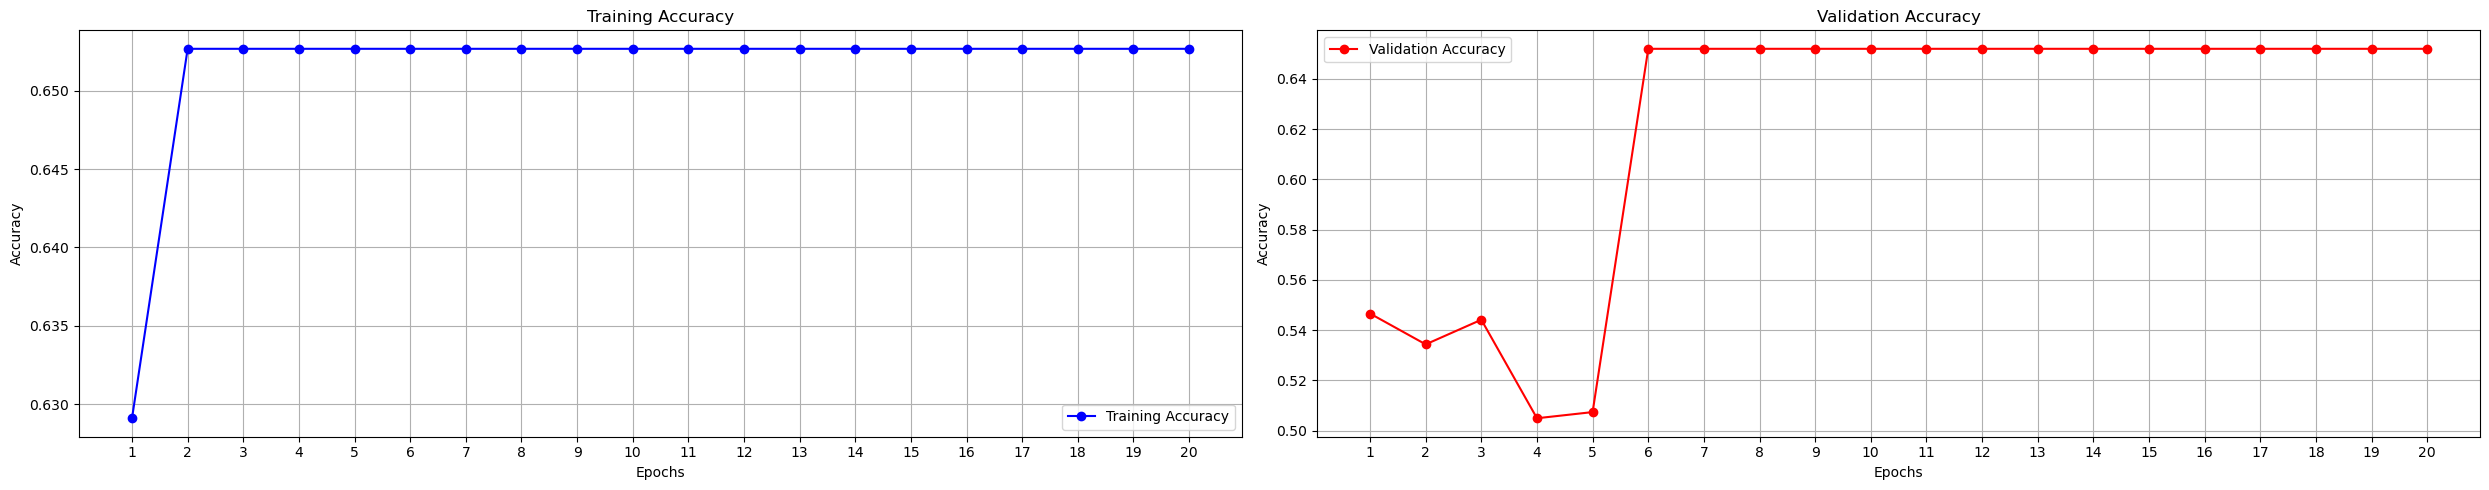

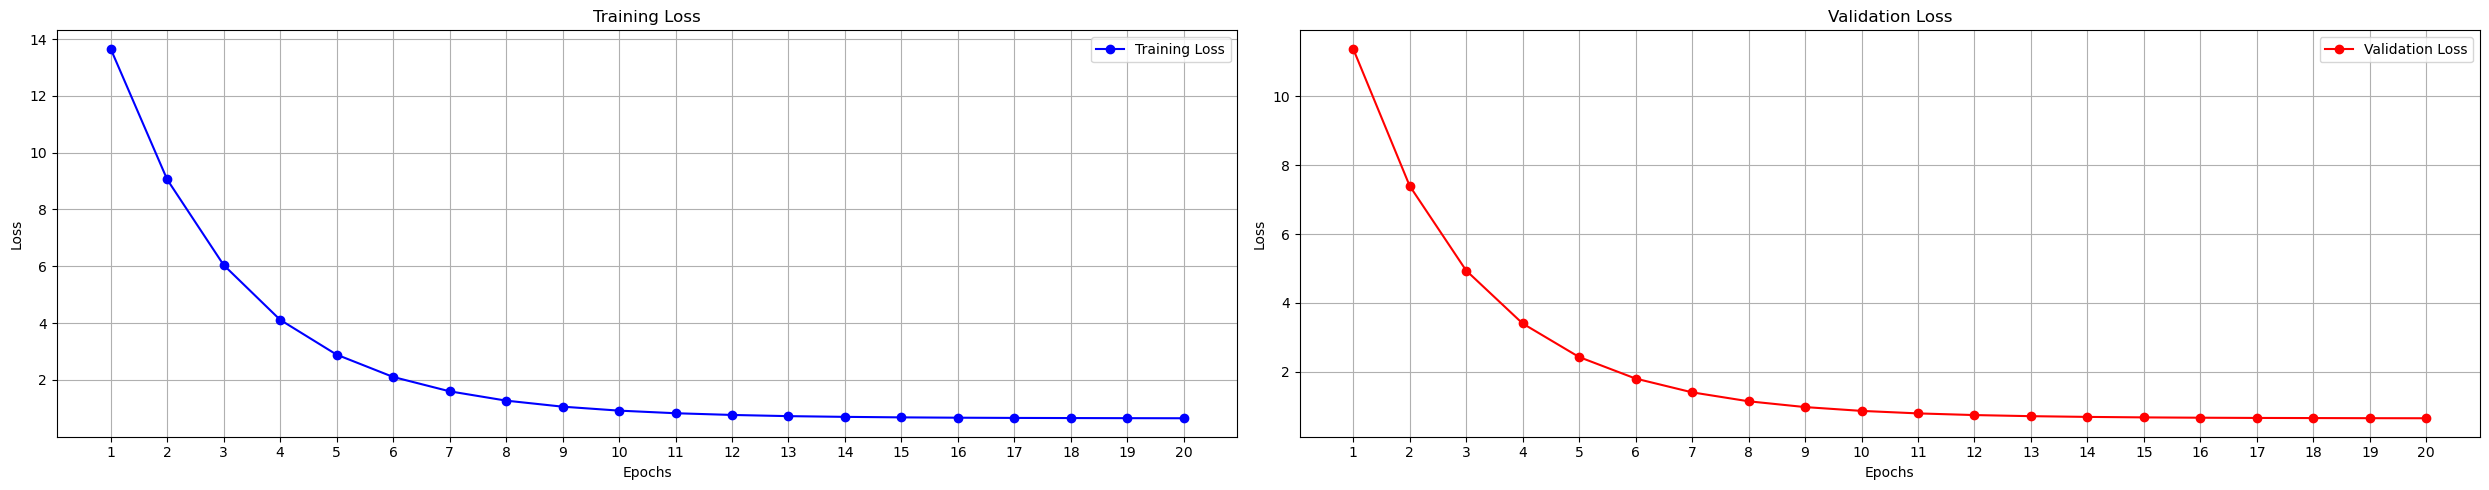

Parameter values appended to: parameter.csv
Accuracy and Loss history saved to history.csv


In [18]:
model.save('CNN.h5')
with open('model_and_classes.json', 'w') as json_file:
    json.dump(class_label_mapping, json_file)

plot_metric(history,  metric_type='accuracy')  # Plot accuracy
plot_metric(history,  metric_type='loss')  # Plot  loss

parameters_csv_file = 'parameter.csv'

# Save the parameter values to the CSV file
save_parameters_to_csv(variable_values, parameters_csv_file)

# Close the script by displaying the saved parameters file path
print(f"Parameter values appended to: {parameters_csv_file}")


# Assuming you have already trained your model and have the 'history' object

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
# Define a file name for your CSV file
csv_filename = "history.csv"

# Write the loss values to the CSV file
with open(csv_filename, mode='w', newline='') as file:
    writer = csv.writer(file)

    if file.tell() == 0:
        writer.writerow(['Epoch', 'Train Accuracy', 'Train Loss', 'Validation Accuracy', 'Validation Loss', 'Test Accuracy', 'Test Loss'])

    for epoch, (train_accuracy_value, train_loss_value, val_accuracy_value, val_loss_value) in enumerate(zip(train_accuracy, train_loss, val_accuracy, val_loss), 1):
        writer.writerow([epoch, train_accuracy_value, train_loss_value, val_accuracy_value, val_loss_value])

    # After the final epoch, add the test accuracy and test loss
    writer.writerow(['Final', '', '', '', '', test_accuracy, test_loss])

print(f"Accuracy and Loss history saved to {csv_filename}")
